In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import scipy.stats as st
from scipy.stats import chi2_contingency
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.stats.api as sms
from statsmodels.formula.api import ols
import sklearn
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn import decomposition
from sklearn import linear_model
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder

In [2]:
def calc_anova(x,y,data):
    
    k = len(pd.unique(data[x]))  # nombre de groupes
    N = len(data.values)  # taille de l'échantillon
    n = data.groupby(x).size() # nb de valeurs par groupes
    
    # DF = Degré de liberté
    
    DFbetween = k - 1
    DFwithin = N - k
    DFtotal = N - 1

    moyenne_y = data[y].mean()

    classes = []

    for classe in data[x].unique():

        yi_classe = data[y][data[x]==classe]

        classes.append({'ni': len(yi_classe),
                        'moyenne_classe': yi_classe.mean(),
                       'variance_classe': yi_classe.var(ddof=0)})

    SCT = sum([(yj-moyenne_y)**2 for yj in data[y]])

    SCE = sum([c['ni']*(c['moyenne_classe']-moyenne_y)**2 for c in classes])
    
    SCR = sum([c['ni']*(c['variance_classe']) for c in classes])
    
    
   
    
    
    MSbetween = SCE/DFbetween
    MSwithin = SCR/DFwithin
    F_value = MSbetween/MSwithin
    p_value = st.f.sf(F_value, DFbetween, DFwithin)
    
    resultat = dict({'SCE':round(SCE,3),'SCT':round(SCT,3),'SCR':round(SCR,3),'eta_squared':SCE/SCT,'Valeur_F':F_value,'P-valeur':p_value})

    return resultat

def display_circles(pcs, n_comp, pca, axis_ranks, labels=None, label_rotation=0, lims=None):
    for d1, d2 in axis_ranks: # On affiche les 3 premiers plans factoriels, donc les 6 premières composantes
        if d2 < n_comp:

            # initialisation de la figure
            fig, ax = plt.subplots(figsize=(7,6))

            # détermination des limites du graphique
            if lims is not None :
                xmin, xmax, ymin, ymax = lims
            elif pcs.shape[1] < 30 :
                xmin, xmax, ymin, ymax = -1, 1, -1, 1
            else :
                xmin, xmax, ymin, ymax = min(pcs[d1,:]), max(pcs[d1,:]), min(pcs[d2,:]), max(pcs[d2,:])

            # affichage des flèches
            # s'il y a plus de 30 flèches, on n'affiche pas le triangle à leur extrémité
            if pcs.shape[1] < 30 :
                plt.quiver(np.zeros(pcs.shape[1]), np.zeros(pcs.shape[1]),
                   pcs[d1,:], pcs[d2,:], 
                   angles='xy', scale_units='xy', scale=1, color="grey")
                # (voir la doc : https://matplotlib.org/api/_as_gen/matplotlib.pyplot.quiver.html)
            else:
                lines = [[[0,0],[x,y]] for x,y in pcs[[d1,d2]].T]
                ax.add_collection(LineCollection(lines, axes=ax, alpha=.1, color='black'))
            
            # affichage des noms des variables  
            if labels is not None:  
                for i,(x, y) in enumerate(pcs[[d1,d2]].T):
                    if x >= xmin and x <= xmax and y >= ymin and y <= ymax :
                        plt.text(x, y, labels[i], fontsize='14', ha='center', va='center', rotation=label_rotation, color="blue", alpha=0.5)
            
            # affichage du cercle
            circle = plt.Circle((0,0), 1, facecolor='none', edgecolor='b')
            plt.gca().add_artist(circle)

            # définition des limites du graphique
            plt.xlim(xmin, xmax)
            plt.ylim(ymin, ymax)
        
            # affichage des lignes horizontales et verticales
            plt.plot([-1, 1], [0, 0], color='grey', ls='--')
            plt.plot([0, 0], [-1, 1], color='grey', ls='--')

            # nom des axes, avec le pourcentage d'inertie expliqué
            plt.xlabel('F{} ({}%)'.format(d1+1, round(100*pca.explained_variance_ratio_[d1],1)))
            plt.ylabel('F{} ({}%)'.format(d2+1, round(100*pca.explained_variance_ratio_[d2],1)))

            plt.title("Cercle des corrélations (F{} et F{})".format(d1+1, d2+1))
            plt.show(block=False)
            
            
            
def display_factorial_planes(X_projected, n_comp, pca, axis_ranks, labels=None, alpha=1, illustrative_var=None):
    for d1,d2 in axis_ranks:
        if d2 < n_comp:
 
            # initialisation de la figure       
            fig = plt.figure(figsize=(7,6))
        
            # affichage des points
            if illustrative_var is None:
                plt.scatter(X_projected[:, d1], X_projected[:, d2], alpha=alpha)
            else:
                illustrative_var = np.array(illustrative_var)
                for value in np.unique(illustrative_var):
                    selected = np.where(illustrative_var == value)
                    plt.scatter(X_projected[selected, d1], X_projected[selected, d2], alpha=alpha, label=value)
                plt.legend()

            # affichage des labels des points
            if labels is not None:
                for i,(x,y) in enumerate(X_projected[:,[d1,d2]]):
                    plt.text(x, y, labels[i],
                              fontsize='14', ha='center',va='center') 
                
            # détermination des limites du graphique
            boundary = np.max(np.abs(X_projected[:, [d1,d2]])) * 1.1
            plt.xlim([-boundary,boundary])
            plt.ylim([-boundary,boundary])
        
            # affichage des lignes horizontales et verticales
            plt.plot([-100, 100], [0, 0], color='grey', ls='--')
            plt.plot([0, 0], [-100, 100], color='grey', ls='--')

            # nom des axes, avec le pourcentage d'inertie expliqué
            plt.xlabel('F{} ({}%)'.format(d1+1, round(100*pca.explained_variance_ratio_[d1],1)))
            plt.ylabel('F{} ({}%)'.format(d2+1, round(100*pca.explained_variance_ratio_[d2],1)))

            plt.title("Projection des individus (sur F{} et F{})".format(d1+1, d2+1))
            plt.show(block=False)
            
            

def display_scree_plot(pca):
    scree = pca.explained_variance_ratio_*100
    plt.bar(np.arange(len(scree))+1, scree)
    plt.plot(np.arange(len(scree))+1, scree.cumsum(),c="red",marker='o')
    plt.xlabel("rang de l'axe d'inertie")
    plt.ylabel("pourcentage d'inertie")
    plt.title("Eboulis des valeurs propres")
    plt.show(block=False)

In [3]:
df_train = pd.read_csv("C:/Users/KyRun69/Desktop/Cours_Openclassrooms/Projets/Projet_8/df_train_cleaned_P8.csv",sep='\t')

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2785: DtypeWarning: Columns (2,8,22) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
df_train=df_train[df_train.visitNumber<100]
df_train=df_train[df_train.pageviews<60]
df_train=df_train[df_train.hits<100]

In [5]:
df_train=df_train[df_train.browser.isin(["Chrome","Safari","Edge","Firefox","Internet Explorer"])]
df_train["browser"]=df_train["browser"].replace("Internet Explorer","IE")
df_train=df_train[df_train["operatingSystem"].isin(["Android","Chrome OS","iOS","Linux","Macintosh","Samsung","Windows"])]
df_train=df_train[df_train.pageviews.isnull()==False]
df_train=df_train[df_train.transactionRevenue!=1870]
df_train=df_train[df_train.transactionRevenue!=2091]
df_train=df_train[df_train.transactionRevenue!=3026]
df_train=df_train[df_train.transactionRevenue!=3301]
df_train=df_train[df_train.transactionRevenue!=3518]
df_train=df_train[df_train.transactionRevenue!=4198]
df_train=df_train[df_train.transactionRevenue!=8677]
df_train["transactionRevenue"]=df_train["transactionRevenue"].replace(np.nan,0)

df_acp=df_train.copy()
df_acp.timeOnSite=df_acp.timeOnSite.replace(np.nan,1)
df_acp=df_acp[df_acp.sessionQualityDim.isna()==False]
df_acp["newVisits"]=df_acp["newVisits"].replace(np.nan,False)
df_acp["newVisits"]=df_acp["newVisits"].replace(1,True)
df_acp["isTrueDirect"]=df_acp["isTrueDirect"].replace(np.nan,False)
df_acp["isMobile"]=df_acp["isMobile"].replace(np.nan,False)
df_acp["jour"]=df_train.date.copy()
df_acp['jour'] = pd.to_datetime(df_acp['jour'])
df_acp["jour"]=df_acp["jour"].dt.weekday
df_acp["Chrome"]=df_acp["browser"].copy()
df_acp["OS"]=df_acp["operatingSystem"].copy()
df_acp=df_acp[df_acp.country.isna()==False]

LE = LabelEncoder()
df_acp['country'] = LE.fit_transform(df_acp['country'])
df_acp.visitStartTime=pd.to_datetime(df_acp.visitStartTime)
df_acp["heure"]=df_acp.visitStartTime.dt.hour
df_acp["heure"]=pd.to_numeric(df_acp.heure)
df_acp["bounces"]=df_acp["bounces"].replace(np.nan,False)
total_pageviews=df_acp.groupby("fullVisitorId").pageviews.sum()
total_pageviews=pd.DataFrame(total_pageviews)
total_pageviews=total_pageviews.rename(columns={"pageviews":"totalPageviews"})
df_acp=pd.merge(df_acp,total_pageviews,how="left",on='fullVisitorId')
df_acp.timeOnSite=pd.to_numeric(df_acp.timeOnSite)
df_acp=df_acp[df_acp.channelGrouping!='(Other)']
df_acp=df_acp[df_acp.channelGrouping.isna()==False]
df_acp["achat"]=df_acp["achat"].replace("oui",1)
df_acp["achat"]=df_acp["achat"].replace("non",0)
nb_visit=df_acp.groupby("fullVisitorId").fullVisitorId.count()
nb_visit=pd.DataFrame(nb_visit)
nb_visit=nb_visit.rename(columns={'fullVisitorId':'nbVisites'})
df_acp=pd.merge(df_acp,nb_visit,how="left",on="fullVisitorId")
df_acp_unique=df_acp[df_acp.nbVisites==1]
df_acp_multi=df_acp[df_acp.nbVisites>1]
df_achat=pd.DataFrame(df_acp_multi.groupby("fullVisitorId").achat.sum())
df_achat=df_achat.rename(columns={"achat":"total_Achat"})
df_acp_multi=pd.merge(df_acp_multi,df_achat,how="left",on='fullVisitorId')
df_acp_multi_2=df_acp_multi[df_acp_multi.total_Achat>0][df_acp_multi.achat>0]
df_acp_multi_3=df_acp_multi[df_acp_multi.total_Achat==0].drop_duplicates(subset="fullVisitorId")
df_acp_multi_4=pd.merge(df_acp_multi_2,df_acp_multi_3,how="outer")
df_acp_multi_4=df_acp_multi_4.drop(columns={"total_Achat"})
df_acp=pd.merge(df_acp_unique,df_acp_multi_4,how="outer")
df_acp["achat"]=df_acp["achat"].replace(1,"oui")
df_acp["achat"]=df_acp["achat"].replace(0,"non")

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


In [6]:
#Hypothèse H0 : les deux variables sont indépendantes

X = "achat"
Y = "timeOnSite" 
calc_anova(X,Y,df_acp)

#P-value < seuil de 5%  on rejette donc l'hypothèse. Les deux variables sont donc corrélées

{'SCE': 429882252.315,
 'SCT': 6700465552.883,
 'SCR': 6270583300.565,
 'eta_squared': 0.06415707220966634,
 'Valeur_F': 4922.550864195728,
 'P-valeur': 0.0}

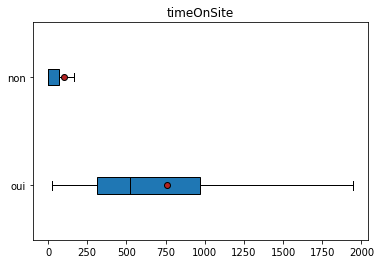

In [7]:
sous_echantillon=df_acp.copy()
modalites = ["oui","non"]
groupes = []
for m in modalites:
    groupes.append(sous_echantillon[sous_echantillon[X]==m][Y])

    
medianprops = {'color':"black"}
meanprops = {'marker':'o', 'markeredgecolor':'black',
            'markerfacecolor':'firebrick'}
    
plt.boxplot(groupes, labels=modalites, showfliers=False, medianprops=medianprops, 
            vert=False, patch_artist=True, showmeans=True, meanprops=meanprops)
plt.title(Y)
plt.show()

In [8]:
#Hypothèse H0 : les deux variables sont indépendantes

X = "achat"
Y = "nbVisites" 
calc_anova(X,Y,df_acp)

#P-value < seuil de 5%  on rejette donc l'hypothèse. Les deux variables sont donc corrélées

{'SCE': 585.113,
 'SCT': 33549.275,
 'SCR': 32964.162,
 'eta_squared': 0.01744041065768722,
 'Valeur_F': 1274.5193883894806,
 'P-valeur': 1.0517697726551464e-276}

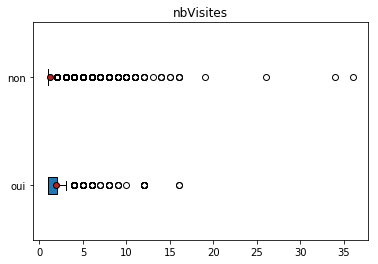

In [9]:
sous_echantillon=df_acp.copy()
modalites = ["oui","non"]
groupes = []
for m in modalites:
    groupes.append(sous_echantillon[sous_echantillon[X]==m][Y])

    
medianprops = {'color':"black"}
meanprops = {'marker':'o', 'markeredgecolor':'black',
            'markerfacecolor':'firebrick'}
    
plt.boxplot(groupes, labels=modalites, medianprops=medianprops, 
            vert=False, patch_artist=True, showmeans=True, meanprops=meanprops)
plt.title(Y)
plt.show()

In [10]:
#Hypothèse H0 : les deux variables sont indépendantes

X = "achat"
Y = "totalPageviews" 
calc_anova(X,Y,df_acp)

#P-value < seuil de 5%  on rejette donc l'hypothèse. Les deux variables sont donc corrélées

{'SCE': 476117.994,
 'SCT': 3344933.749,
 'SCR': 2868815.755,
 'eta_squared': 0.14234003711492688,
 'Valeur_F': 11916.825393852787,
 'P-valeur': 0.0}

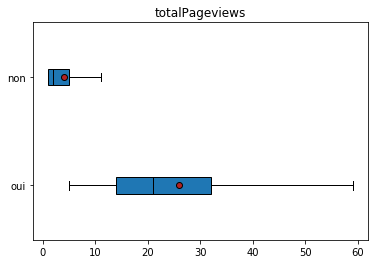

In [11]:
sous_echantillon=df_acp.copy()
modalites = ["oui","non"]
groupes = []
for m in modalites:
    groupes.append(sous_echantillon[sous_echantillon[X]==m][Y])

    
medianprops = {'color':"black"}
meanprops = {'marker':'o', 'markeredgecolor':'black',
            'markerfacecolor':'firebrick'}
    
plt.boxplot(groupes, labels=modalites, showfliers=False, medianprops=medianprops, 
            vert=False, patch_artist=True, showmeans=True, meanprops=meanprops)
plt.title(Y)
plt.show()

In [12]:
#Hypothèse H0 : les deux variables sont indépendantes

X = "achat"
Y = "visitNumber" 
calc_anova(X,Y,df_acp)

#P-value < seuil de 5%  on rejette donc l'hypothèse. Les deux variables sont donc corrélées

{'SCE': 2811.514,
 'SCT': 626030.027,
 'SCR': 623218.513,
 'eta_squared': 0.0044910206474466936,
 'Valeur_F': 323.92801396824774,
 'P-valeur': 2.913889429385737e-72}

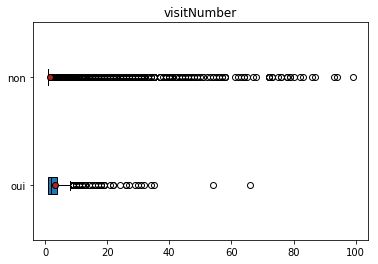

In [13]:
sous_echantillon=df_acp.copy()
modalites = ["oui","non"]
groupes = []
for m in modalites:
    groupes.append(sous_echantillon[sous_echantillon[X]==m][Y])

    
medianprops = {'color':"black"}
meanprops = {'marker':'o', 'markeredgecolor':'black',
            'markerfacecolor':'firebrick'}
    
plt.boxplot(groupes, labels=modalites, medianprops=medianprops, 
            vert=False, patch_artist=True, showmeans=True, meanprops=meanprops)
plt.title(Y)
plt.show()

In [14]:
#Hypothèse H0 : les deux variables sont indépendantes

X = "achat"
Y = "hits" 
calc_anova(X,Y,df_acp)

#P-value < seuil de 5%  on rejette donc l'hypothèse. Les deux variables sont donc corrélées

{'SCE': 467249.576,
 'SCT': 3478605.551,
 'SCR': 3011355.975,
 'eta_squared': 0.1343209424595447,
 'Valeur_F': 11141.289451740915,
 'P-valeur': 0.0}

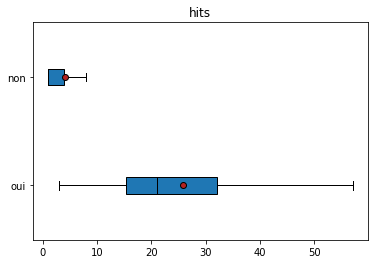

In [15]:
sous_echantillon=df_acp.copy()
modalites = ["oui","non"]
groupes = []
for m in modalites:
    groupes.append(sous_echantillon[sous_echantillon[X]==m][Y])

    
medianprops = {'color':"black"}
meanprops = {'marker':'o', 'markeredgecolor':'black',
            'markerfacecolor':'firebrick'}
    
plt.boxplot(groupes, labels=modalites, showfliers=False, medianprops=medianprops, 
            vert=False, patch_artist=True, showmeans=True, meanprops=meanprops)
plt.title(Y)
plt.show()

In [16]:
#Hypothèse H0 : les deux variables sont indépendantes

X = "achat"
Y= "pageviews"
calc_anova(X,Y,df_acp)

#P-value < seuil de 5%  on rejette donc l'hypothèse. Les deux variables sont donc corrélées

{'SCE': 243075.52,
 'SCT': 1831424.741,
 'SCR': 1588349.221,
 'eta_squared': 0.13272482042258027,
 'Valeur_F': 10988.638012520572,
 'P-valeur': 0.0}

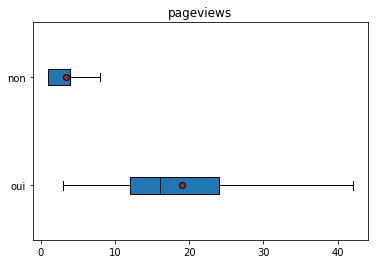

In [17]:
sous_echantillon=df_acp.copy()
modalites = ["oui","non"]
groupes = []
for m in modalites:
    groupes.append(sous_echantillon[sous_echantillon[X]==m][Y])

    
medianprops = {'color':"black"}
meanprops = {'marker':'o', 'markeredgecolor':'black',
            'markerfacecolor':'firebrick'}
    
plt.boxplot(groupes, labels=modalites, medianprops=medianprops,showfliers=False,
            vert=False, patch_artist=True, showmeans=True, meanprops=meanprops)
plt.title(Y)
plt.show()

In [18]:
#Hypothèse H0 : les deux variables sont indépendantes

X = "achat"
Y = "sessionQualityDim"
calc_anova(X,Y,df_acp)

#P-value < seuil de 5%  on rejette donc l'hypothèse. Les deux variables sont donc corrélées

{'SCE': 3895751.846,
 'SCT': 10763060.821,
 'SCR': 6867308.975,
 'eta_squared': 0.36195575878399366,
 'Valeur_F': 40733.65077973776,
 'P-valeur': 0.0}

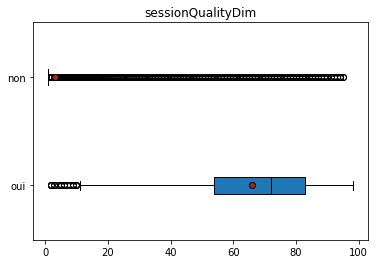

In [19]:
sous_echantillon=df_acp.copy()
modalites = ["oui","non"]
groupes = []
for m in modalites:
    groupes.append(sous_echantillon[sous_echantillon[X]==m][Y])

    
medianprops = {'color':"black"}
meanprops = {'marker':'o', 'markeredgecolor':'black',
            'markerfacecolor':'firebrick'}
    
plt.boxplot(groupes, labels=modalites, medianprops=medianprops, 
            vert=False, patch_artist=True, showmeans=True, meanprops=meanprops)
plt.title(Y)
plt.show()

In [20]:
#Hypothèse H0 : les deux variables sont indépendantes

X = "achat"
Y = "heure"
calc_anova(X,Y,df_acp)

#P-value < seuil de 5%  on rejette donc l'hypothèse. Les deux variables sont donc corrélées

{'SCE': 2489.133,
 'SCT': 3453410.764,
 'SCR': 3450921.631,
 'eta_squared': 0.0007207753011210462,
 'Valeur_F': 51.79188002960839,
 'P-valeur': 6.230746262031369e-13}

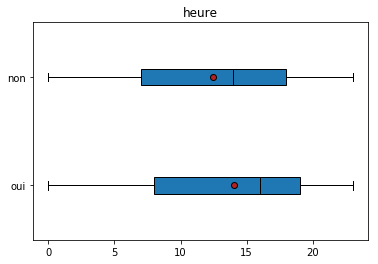

In [21]:
sous_echantillon=df_acp.copy()
modalites = ["oui","non"]
groupes = []
for m in modalites:
    groupes.append(sous_echantillon[sous_echantillon[X]==m][Y])

    
medianprops = {'color':"black"}
meanprops = {'marker':'o', 'markeredgecolor':'black',
            'markerfacecolor':'firebrick'}
    
plt.boxplot(groupes, labels=modalites, medianprops=medianprops, 
            vert=False, patch_artist=True, showmeans=True, meanprops=meanprops)
plt.title(Y)
plt.show()

In [22]:
#Hypothèse H0 : On suppose les variables achat et newVisit d'être indépendantes.

sous_echantillon=df_acp.copy()

X = "achat"
Y = "newVisits"

c = sous_echantillon[[X,Y]].pivot_table(index=X,columns=Y,aggfunc=len)
cont = c.copy()

obs=cont
chi2, p, dof, expected = st.chi2_contingency(obs)
print (chi2)
print (p)
#P value = 0%  < 5%  on rejette donc l'hypothèse. Les deux variables sont corrélées

1162.040482389977
1.0841063136573737e-254


In [23]:
#Hypothèse H0 : On suppose les variables achat et isTrueDirect d'être indépendantes. 

sous_echantillon=df_acp.copy()

X = "achat"
Y = "isTrueDirect"

c = sous_echantillon[[X,Y]].pivot_table(index=X,columns=Y,aggfunc=len)
cont = c.copy()

obs=cont
chi2, p, dof, expected = st.chi2_contingency(obs)
print (chi2)
print (p)


# P value = 100%  < 5%  on rejette donc l'hypothèse. Les deux variables sont corrélées

996.1412277659094
1.2388693500196754e-218


In [24]:
#Hypothèse H0 : On suppose les variables achat et jour d'être indépendantes

sous_echantillon=df_acp.copy()

X = "achat"
Y = "jour"

c = sous_echantillon[[X,Y]].pivot_table(index=X,columns=Y,aggfunc=len)
cont = c.copy()

obs=cont
chi2, p, dof, expected = st.chi2_contingency(obs)
print (chi2)
print (p)

# P value = 0%  < 5%  on rejette donc l'hypothèse. Les deux variables sont corrélées

209.65416025728513
1.6687064881869864e-42


In [25]:
#Hypothèse H0 : On suppose les variables achat et Chrome d'être indépendantes.

sous_echantillon=df_acp[df_acp.Chrome!="Edge"].copy()

X = "achat"
Y = "Chrome"

c = sous_echantillon[[X,Y]].pivot_table(index=X,columns=Y,aggfunc=len)
cont = c.copy()

obs=cont
chi2, p, dof, expected = st.chi2_contingency(obs)
print (chi2)
print (p)

# P value = 0%  < 5%  on rejette donc l'hypothèse. Les deux variables sont corrélées

147.15213803156115
1.0840876437072503e-31


In [26]:
#Hypothèse H0 : On suppose les variables achat et channelGrouping d'être indépendantes. 

sous_echantillon=df_acp[df_acp["channelGrouping"]!="Affiliates"].copy()

X = "achat"
Y = "channelGrouping"

c = sous_echantillon[[X,Y]].pivot_table(index=X,columns=Y,aggfunc=len)
cont = c.copy()

obs=cont
chi2, p, dof, expected = st.chi2_contingency(obs)
print (chi2)
print (p)
print(expected)

# P value = 100%  > 5%  on ne rejette donc pas l'hypothèse. Les deux variables ne sont pas corrélées

851.2981807795722
9.21339619081435e-182
[[1.19325349e+04 6.00273729e+02 3.19150461e+04 1.49132045e+03
  9.96414964e+03 1.32986751e+04]
 [1.73465075e+02 8.72627051e+00 4.63953880e+02 2.16795522e+01
  1.44850359e+02 1.93324863e+02]]


In [27]:
#Hypothèse H0 : On suppose les variables achat et OS d'être indépendantes.

sous_echantillon=df_acp.copy()

X = "achat"
Y = "OS"

c = sous_echantillon[[X,Y]].pivot_table(index=X,columns=Y,aggfunc=len)
cont = c.copy()

obs=cont
chi2, p, dof, expected = st.chi2_contingency(obs)
print (chi2)
print (p)
print(expected)

# P value = 0%  < 5%  on rejette donc l'hypothèse. Les deux variables sont corrélées

838.3230894493942
5.914843711815437e-179
[[10151.75333538  2915.57251483  3604.77954488 18861.00325878
  26972.7432248   8294.14812133]
 [  144.24666462    41.42748517    51.22045512   267.99674122
    383.2567752    117.85187867]]


In [28]:
#Hypothèse H0 : On suppose les variables achat et isMobile d'être indépendantes

sous_echantillon=df_acp.copy()

X = "achat"
Y = "isMobile"

c = sous_echantillon[[X,Y]].pivot_table(index=X,columns=Y,aggfunc=len)
cont = c.copy()

obs=cont
chi2, p, dof, expected = st.chi2_contingency(obs)
print (chi2)
print (p)
print(expected)
# P value = 0%  < 5%  on rejette donc l'hypothèse. Les deux variables sont corrélées

200.72797369903049
1.4486822890149752e-45
[[52237.75171991 18562.24828009]
 [  742.24828009   263.75171991]]


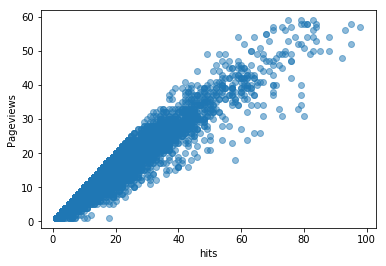

(-0.9769777521928132, 0.0)
SpearmanrResult(correlation=-0.9908217471311525, pvalue=0.0)


In [29]:
#Hypothèse H0 : On suppose les variables hits et pageviews d'être indépendantes.

df_acp.pageviews=pd.to_numeric(df_acp.pageviews)

plt.plot(df_acp.hits,df_acp.pageviews,'o',alpha=0.5)
plt.xlabel("hits")
plt.ylabel("Pageviews")
plt.show()

print(st.pearsonr(df_acp.hits,-df_acp.pageviews))
print(st.spearmanr(df_acp.hits,-df_acp.pageviews))

#P value = 0%  < 5%  on rejette donc l'hypothèse. Les deux variables sont corrélées

In [30]:
#Hypothèse H0 : On suppose les variables newVisits et isTrueDirect d'être indépendantes

sous_echantillon=df_acp.copy()

X = "newVisits"
Y = "isTrueDirect"

c = sous_echantillon[[X,Y]].pivot_table(index=X,columns=Y,aggfunc=len)
cont = c.copy()

obs=cont
chi2, p, dof, expected = st.chi2_contingency(obs)
print (chi2)
print (p)
print(expected)

# P value = 0%  < 5%  on rejette donc l'hypothèse. Les deux variables sont corrélées

19363.39408546063
0.0
[[ 9164.88677826  3570.11322174]
 [42511.11322174 16559.88677826]]


In [31]:
df_acp["achat"]=df_acp["achat"].replace("oui",1)
df_acp["achat"]=df_acp["achat"].replace("non",0)
df_acp["Chrome"]=df_acp["Chrome"].replace("Chrome",0)
df_acp["Chrome"]=df_acp["Chrome"].replace("Safari",1)
df_acp["Chrome"]=df_acp["Chrome"].replace("Firefox",2)
df_acp["Chrome"]=df_acp["Chrome"].replace("IE",3)
df_acp["Chrome"]=df_acp["Chrome"].replace("Edge",4)
df_acp["OS"]=df_acp["OS"].replace("Windows",0)
df_acp["OS"]=df_acp["OS"].replace("Android",1)
df_acp["OS"]=df_acp["OS"].replace("iOS",2)
df_acp["OS"]=df_acp["OS"].replace("Macintosh",3)
df_acp["OS"]=df_acp["OS"].replace("Chrome OS",4)
df_acp["OS"]=df_acp["OS"].replace("Linux",5)
df_acp["channelGrouping"]=df_acp["channelGrouping"].replace("Organic Search","0")
df_acp["channelGrouping"]=df_acp["channelGrouping"].replace("Referral","1")
df_acp["channelGrouping"]=df_acp["channelGrouping"].replace("Paid Search","2")
df_acp["channelGrouping"]=df_acp["channelGrouping"].replace("Affiliates","3")
df_acp["channelGrouping"]=df_acp["channelGrouping"].replace("Direct","4")
df_acp["channelGrouping"]=df_acp["channelGrouping"].replace("Display","5")
df_acp["channelGrouping"]=df_acp["channelGrouping"].replace("Social","6")

In [32]:
# ACP

In [33]:
df_acp=df_acp.drop(69132)
df_acp=df_acp.drop(12314)
df_acp=df_acp.drop(49079)

In [34]:
df_acp=df_acp[["achat","totalPageviews","hits","newVisits","timeOnSite","pageviews","sessionQualityDim","isTrueDirect","OS","jour","isMobile","nbVisites","channelGrouping","visitNumber","Chrome"]]

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


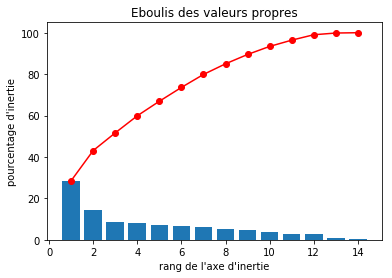

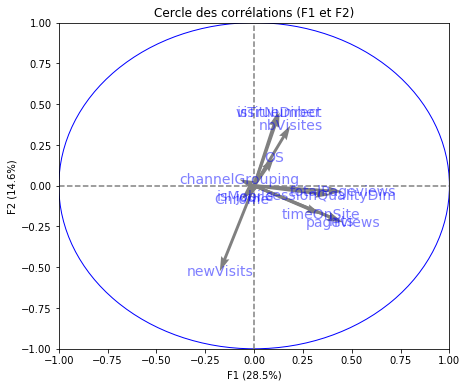

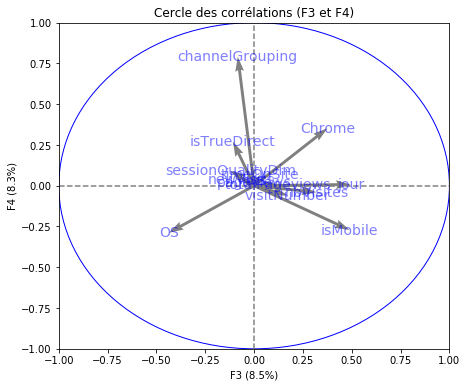

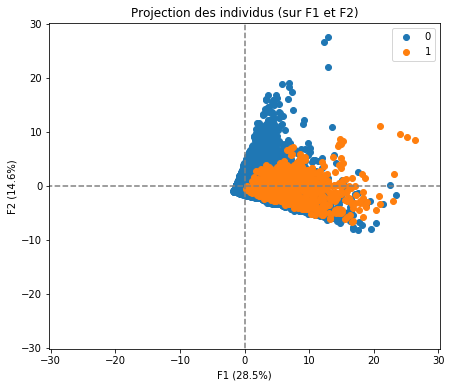

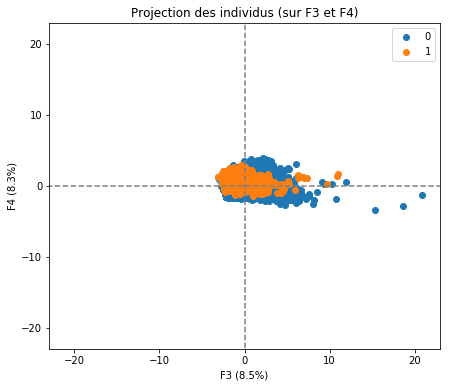

In [35]:
# choix du nombre de composantes à calculer
n_comp = 14

# import de l'échantillon
X = df_acp[["totalPageviews","hits","newVisits","timeOnSite","pageviews","sessionQualityDim","isTrueDirect","OS","jour","isMobile","nbVisites","channelGrouping","visitNumber","Chrome"]].values
std_scale = preprocessing.StandardScaler().fit(X)
X_scaled = std_scale.transform(X)

# Calcul des composantes principales
pca = decomposition.PCA(n_components= n_comp)
pca.fit(X_scaled)

# Eboulis des valeurs propres
display_scree_plot(pca)

# Cercle des corrélations
pcs = pca.components_
display_circles(pcs, n_comp, pca, [(0,1)],labels = np.array(df_acp[["totalPageviews","hits","newVisits","timeOnSite","pageviews","sessionQualityDim","isTrueDirect","OS","jour","isMobile","nbVisites","channelGrouping","visitNumber","Chrome"]].columns))
display_circles(pcs, n_comp, pca, [(2,3)],labels = np.array(df_acp[["totalPageviews","hits","newVisits","timeOnSite","pageviews","sessionQualityDim","isTrueDirect","OS","jour","isMobile","nbVisites","channelGrouping","visitNumber","Chrome"]].columns))

# Projection des individus
X_projected = pca.transform(X_scaled)
display_factorial_planes(X_projected, n_comp, pca, [(0,1)],illustrative_var=df_acp.achat)
display_factorial_planes(X_projected, n_comp, pca, [(2,3)],illustrative_var=df_acp.achat)

In [36]:
#contribution des individus dans l'inertie totale
di = np.sum(X_scaled**2,axis=1)
print(pd.DataFrame({'id':df_acp.index,'Contribution dans l_inertie totale':di,'Vrai_Faux':df_acp.achat}).set_index("id").sort_values(by='Contribution dans l_inertie totale', ascending=False).head(10))
print(pd.DataFrame({'id':df_acp.index,'Contribution dans l_inertie totale':di,'Vrai_Faux':df_acp.achat}).set_index("id").sort_values(by='Contribution dans l_inertie totale', ascending=True).head(10))


#qualité de représentation des individus - COS2
cos2 = X_projected**2
for j in range(6):
 cos2[:,j] = cos2[:,j]/di
df_cos2=pd.DataFrame({'id':df_acp.index,'COS2_F1':cos2[:,0],'COS2_F2':cos2[:,1],'COS2_1er_plan_factoriel':cos2[:,0]+cos2[:,1],'Vrai_Faux':df_acp.achat}).set_index("id")

print("\n",df_cos2.sort_values(by='COS2_1er_plan_factoriel',ascending=False).head(10))
print("\n",df_cos2.sort_values(by='COS2_1er_plan_factoriel',ascending=True).head(10))

#Contribution aux axes
n=df_acp.drop(columns="achat").shape[0]
eigval = (n-1)/n*pca.explained_variance_
ctr = X_projected**2
for j in range(12):
 ctr[:,j] = ctr[:,j]/(n*eigval[j])

print("\n",1/(df_acp.timeOnSite.count()))

print("\n",pd.DataFrame({'id':df_acp.index,'CTR_F1':ctr[:,0],'Achat':df_acp.achat}).sort_values(by="CTR_F1",ascending=False).set_index("id").head(10))
print("\n",pd.DataFrame({'id':df_acp.index,'CTR_F1':ctr[:,0],'Achat':df_acp.achat}).sort_values(by="CTR_F1",ascending=True).set_index("id").head(10))
print("\n",pd.DataFrame({'id':df_acp.index,'CTR_F2':ctr[:,1],'Achat':df_acp.achat}).sort_values(by="CTR_F2",ascending=False).set_index("id").head(10))
print("\n",pd.DataFrame({'id':df_acp.index,'CTR_F2':ctr[:,1],'Achat':df_acp.achat}).sort_values(by="CTR_F2",ascending=True).set_index("id").head(10))
print("\n",pd.DataFrame({'id':df_acp.index,'CTR_F3':ctr[:,2],'Achat':df_acp.achat}).sort_values(by="CTR_F3",ascending=False).set_index("id").head(10))
print("\n",pd.DataFrame({'id':df_acp.index,'CTR_F3':ctr[:,2],'Achat':df_acp.achat}).sort_values(by="CTR_F3",ascending=True).set_index("id").head(10))
print("\n",pd.DataFrame({'id':df_acp.index,'CTR_F4':ctr[:,3],'Achat':df_acp.achat}).sort_values(by="CTR_F4",ascending=False).set_index("id").head(10))
print("\n",pd.DataFrame({'id':df_acp.index,'CTR_F4':ctr[:,3],'Achat':df_acp.achat}).sort_values(by="CTR_F4",ascending=True).set_index("id").head(10))
print("\n",pd.DataFrame({'id':df_acp.index,'CTR_F5':ctr[:,4],'Achat':df_acp.achat}).sort_values(by="CTR_F5",ascending=False).set_index("id").head(10))
print("\n",pd.DataFrame({'id':df_acp.index,'CTR_F5':ctr[:,4],'Achat':df_acp.achat}).sort_values(by="CTR_F5",ascending=True).set_index("id").head(10))
print("\n",pd.DataFrame({'id':df_acp.index,'CTR_F6':ctr[:,5],'Achat':df_acp.achat}).sort_values(by="CTR_F6",ascending=False).set_index("id").head(10))
print("\n",pd.DataFrame({'id':df_acp.index,'CTR_F6':ctr[:,5],'Achat':df_acp.achat}).sort_values(by="CTR_F6",ascending=True).set_index("id").head(10))

       Contribution dans l_inertie totale  Vrai_Faux
id                                                  
65469                         2698.205653          0
65707                         2667.811018          0
66001                         1944.048544          0
63777                         1291.628660          1
63769                         1192.566137          1
31449                         1098.301241          0
63706                         1092.665573          1
42748                          989.344469          0
18146                          969.699201          0
65465                          882.052126          0
       Contribution dans l_inertie totale  Vrai_Faux
id                                                  
31979                            2.194298          0
61585                            2.348392          0
44390                            2.353142          0
56320                            2.353142          0
1994                             2.383356     

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


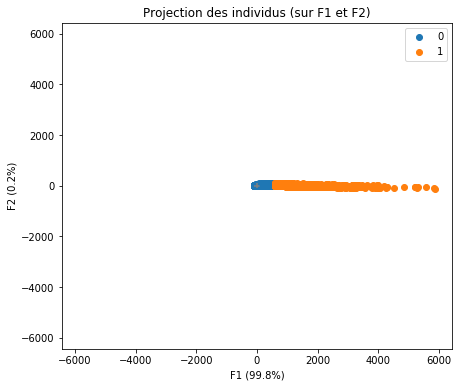

In [37]:
n_clust = 2

X_scaled = preprocessing.StandardScaler().fit_transform(X)
km = KMeans(n_clusters= n_clust)
km.fit(X)

clusters = km.labels_

# Affichage du clustering par projection des individus sur le prmeier plan factoriel
pca = decomposition.PCA(n_components=4).fit(X)
X_projected = pca.transform(X)
display_factorial_planes(X_projected, n_clust, pca, [(0,1)],illustrative_var=clusters)

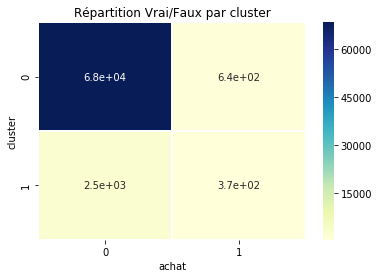

In [38]:
df_clusters = pd.DataFrame({"cluster": clusters,"achat":df_acp.achat})

ax = plt.axes()
sns.heatmap(df_clusters.pivot_table(index="cluster" , columns="achat", aggfunc=len, fill_value=0), annot=True, linewidths=.3, cmap="YlGnBu")
ax.set_title('Répartition Vrai/Faux par cluster')
plt.show()

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


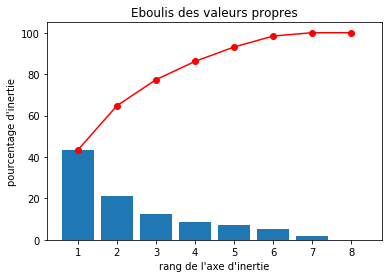

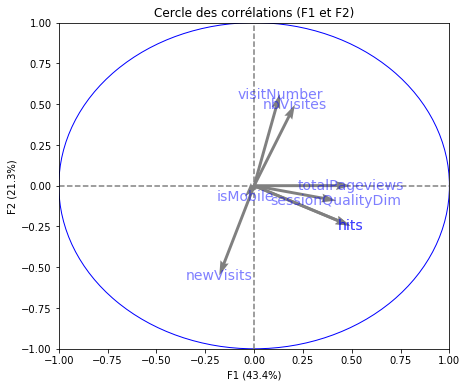

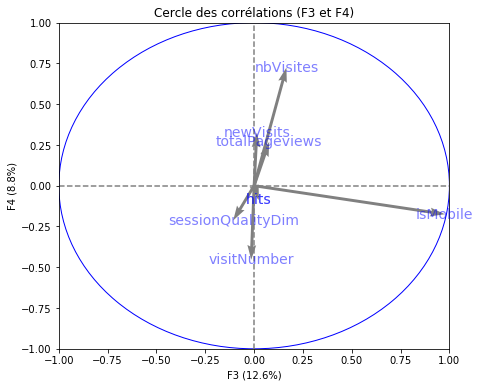

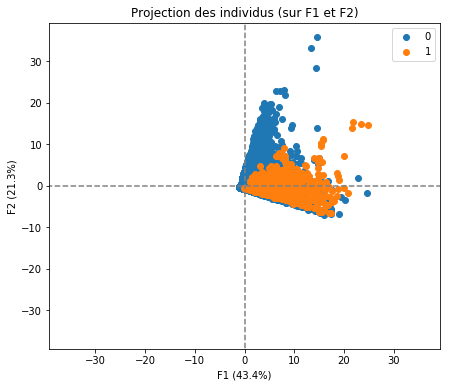

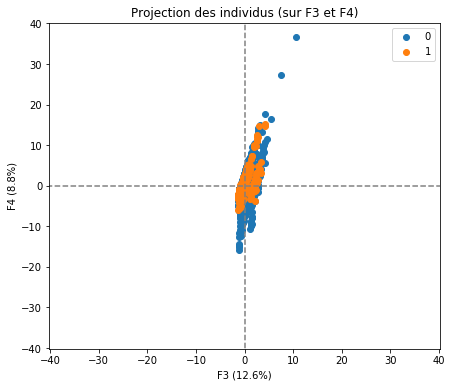

In [39]:
# choix du nombre de composantes à calculer
n_comp = 8

# import de l'échantillon
X = df_acp[["newVisits","hits","sessionQualityDim","nbVisites","totalPageviews","hits","visitNumber","isMobile"]].values
std_scale = preprocessing.StandardScaler().fit(X)
X_scaled = std_scale.transform(X)

# Calcul des composantes principales
pca = decomposition.PCA(n_components= n_comp)
pca.fit(X_scaled)

# Eboulis des valeurs propres
display_scree_plot(pca)

# Cercle des corrélations
pcs = pca.components_
display_circles(pcs, n_comp, pca, [(0,1)],labels = np.array(df_acp[["newVisits","hits","sessionQualityDim","nbVisites","totalPageviews","hits","visitNumber","isMobile"]].columns))
display_circles(pcs, n_comp, pca, [(2,3)],labels = np.array(df_acp[["newVisits","hits","sessionQualityDim","nbVisites","totalPageviews","hits","visitNumber","isMobile"]].columns))

# Projection des individus
X_projected = pca.transform(X_scaled)
display_factorial_planes(X_projected, n_comp, pca, [(0,1)],illustrative_var=df_acp.achat)
display_factorial_planes(X_projected, n_comp, pca, [(2,3)],illustrative_var=df_acp.achat)

In [40]:
# Tests avec sessionQualityDim

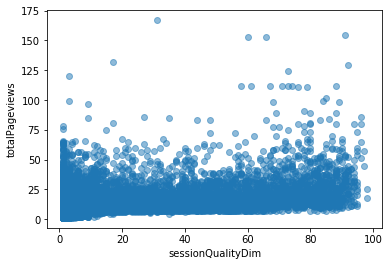

(-0.6134948013844154, 0.0)
SpearmanrResult(correlation=-0.6478484935039228, pvalue=0.0)


In [41]:
#Hypothèse H0 : On suppose les variables sessionQualityDim et totalPageviews d'être indépendantes.

plt.plot(df_acp.sessionQualityDim,df_acp.totalPageviews,'o',alpha=0.5)
plt.xlabel("sessionQualityDim")
plt.ylabel("totalPageviews")
plt.show()

print(st.pearsonr(df_acp.totalPageviews,-df_acp.sessionQualityDim))
print(st.spearmanr(df_acp.totalPageviews,-df_acp.sessionQualityDim))

# Le coefficient de Spearman ne permet pas d'affirmer la corrélation entre les deux variables.

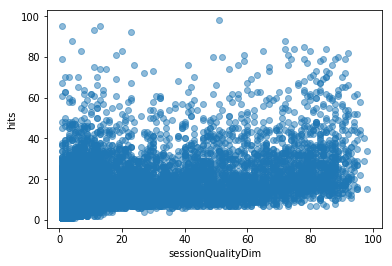

(-0.658054479204503, 0.0)
SpearmanrResult(correlation=-0.6556674576075675, pvalue=0.0)


In [42]:
#Hypothèse H0 : On suppose les variables sessionQualityDim et hits d'être indépendantes.

plt.plot(df_acp.sessionQualityDim,df_acp.hits,'o',alpha=0.5)
plt.xlabel("sessionQualityDim")
plt.ylabel("hits")
plt.show()

print(st.pearsonr(df_acp.sessionQualityDim,-df_acp.hits))
print(st.spearmanr(df_acp.sessionQualityDim,-df_acp.hits))

# Le coefficient de Spearman ne permet pas d'affirmer la corrélation entre les deux variables.

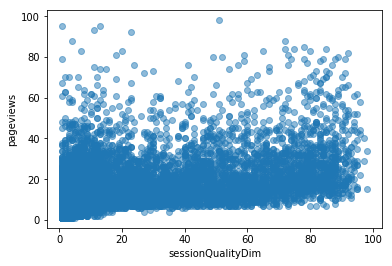

(-0.6649172229535012, 0.0)
SpearmanrResult(correlation=-0.6625615450162637, pvalue=0.0)


In [43]:
#Hypothèse H0 : On suppose les variables sessionQualityDim et pageviews d'être indépendantes.

plt.plot(df_acp.sessionQualityDim,df_acp.hits,'o',alpha=0.5)
plt.xlabel("sessionQualityDim")
plt.ylabel("pageviews")
plt.show()

print(st.pearsonr(df_acp.sessionQualityDim,-df_acp.pageviews))
print(st.spearmanr(df_acp.sessionQualityDim,-df_acp.pageviews))

# Le coefficient de Spearman ne permet pas d'affirmer la corrélation entre les deux variables.

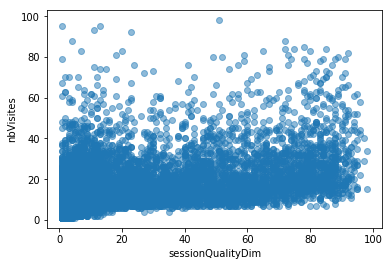

(-0.15235855144941543, 0.0)
SpearmanrResult(correlation=-0.1809385020552839, pvalue=0.0)


In [44]:
#Hypothèse H0 : On suppose les variables sessionQualityDim et nbVisites d'être indépendantes.

plt.plot(df_acp.sessionQualityDim,df_acp.hits,'o',alpha=0.5)
plt.xlabel("sessionQualityDim")
plt.ylabel("nbVisites")
plt.show()

print(st.pearsonr(df_acp.sessionQualityDim,-df_acp.nbVisites))
print(st.spearmanr(df_acp.sessionQualityDim,-df_acp.nbVisites))

# Le coefficient de Spearman ne permet pas d'affirmer la corrélation entre les deux variables.

In [45]:
#Hypothèse H0 : les deux variables sont indépendantes

X = "newVisits"
Y = "sessionQualityDim" 
calc_anova(X,Y,df_acp)

#P-value < seuil de 5%  on rejette donc l'hypothèse. Les deux variables sont donc corrélées

{'SCE': 462727.168,
 'SCT': 10763030.043,
 'SCR': 10300302.875,
 'eta_squared': 0.04299227695044328,
 'Valeur_F': 3225.5627650347856,
 'P-valeur': 0.0}

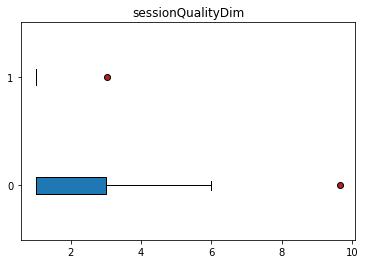

In [46]:
sous_echantillon=df_acp.copy()
modalites = [0,1]
groupes = []
for m in modalites:
    groupes.append(sous_echantillon[sous_echantillon[X]==m][Y])

    
medianprops = {'color':"black"}
meanprops = {'marker':'o', 'markeredgecolor':'black',
            'markerfacecolor':'firebrick'}
    
plt.boxplot(groupes, labels=modalites, showfliers=False, medianprops=medianprops, 
            vert=False, patch_artist=True, showmeans=True, meanprops=meanprops)
plt.title(Y)
plt.show()

In [47]:
#Hypothèse H0 : les deux variables sont indépendantes

X = "isTrueDirect"
Y = "sessionQualityDim" 
calc_anova(X,Y,df_acp)

#P-value < seuil de 5%  on rejette donc l'hypothèse. Les deux variables sont donc corrélées

{'SCE': 338133.501,
 'SCT': 10763030.043,
 'SCR': 10424896.543,
 'eta_squared': 0.03141619965627126,
 'Valeur_F': 2328.8790817275267,
 'P-valeur': 0.0}

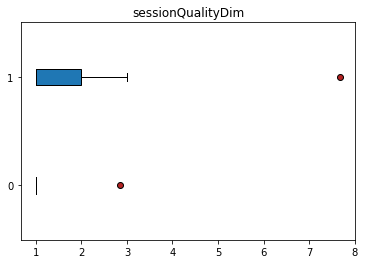

In [48]:
sous_echantillon=df_acp.copy()
modalites = [0,1]
groupes = []
for m in modalites:
    groupes.append(sous_echantillon[sous_echantillon[X]==m][Y])

    
medianprops = {'color':"black"}
meanprops = {'marker':'o', 'markeredgecolor':'black',
            'markerfacecolor':'firebrick'}
    
plt.boxplot(groupes, labels=modalites, showfliers=False, medianprops=medianprops, 
            vert=False, patch_artist=True, showmeans=True, meanprops=meanprops)
plt.title(Y)
plt.show()

In [49]:
# Tests avec totalPageviews

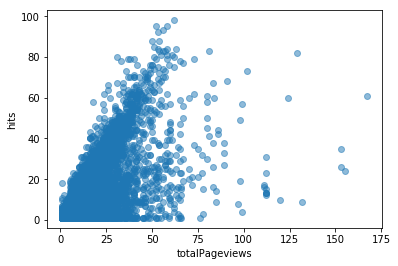

(-0.8139728550096743, 0.0)
SpearmanrResult(correlation=-0.915440021157226, pvalue=0.0)


In [50]:
#Hypothèse H0 : On suppose les variables hits et totalPageviews d'être indépendantes.

plt.plot(df_acp.totalPageviews,df_acp.hits,'o',alpha=0.5)
plt.xlabel("totalPageviews")
plt.ylabel("hits")
plt.show()

print(st.pearsonr(df_acp.totalPageviews,-df_acp.hits))
print(st.spearmanr(df_acp.totalPageviews,-df_acp.hits))

# Le coefficient de Spearman est proche de -1. Les deux variables sont donc corrélées

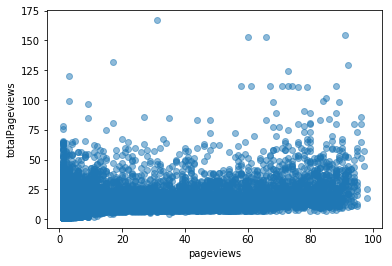

(-0.8300311666270838, 0.0)
SpearmanrResult(correlation=-0.9234387852154625, pvalue=0.0)


In [51]:
#Hypothèse H0 : On suppose les variables pageviews et totalPageviews d'être indépendantes.

plt.plot(df_acp.sessionQualityDim,df_acp.totalPageviews,'o',alpha=0.5)
plt.xlabel("pageviews")
plt.ylabel("totalPageviews")
plt.show()

print(st.pearsonr(df_acp.totalPageviews,-df_acp.pageviews))
print(st.spearmanr(df_acp.totalPageviews,-df_acp.pageviews))

# Le coefficient de Spearman est proche de -1. Les deux variables sont donc corrélées

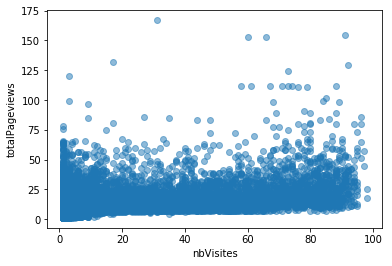

(-0.46355502651063857, 0.0)
SpearmanrResult(correlation=-0.39377920038506625, pvalue=0.0)


In [52]:
#Hypothèse H0 : On suppose les variables nbVisites et totalPageviews d'être indépendantes.

plt.plot(df_acp.sessionQualityDim,df_acp.totalPageviews,'o',alpha=0.5)
plt.xlabel("nbVisites")
plt.ylabel("totalPageviews")
plt.show()

print(st.pearsonr(df_acp.totalPageviews,-df_acp.nbVisites))
print(st.spearmanr(df_acp.totalPageviews,-df_acp.nbVisites))

# Le coefficient de Spearman ne permet pas d'affirmer la corrélation entre les deux variables.


 Le taux d'erreur est donc de :  0.011628716663185015

 Voici le pourcentage de non achat prédit justement : 0.9950561480330532

 Voici le pourcentage d'achat prédit justement : 0.5198019801980198


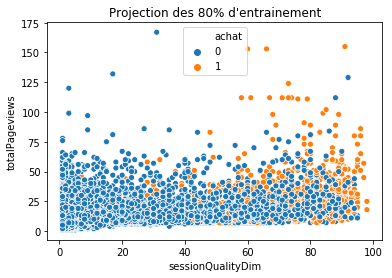

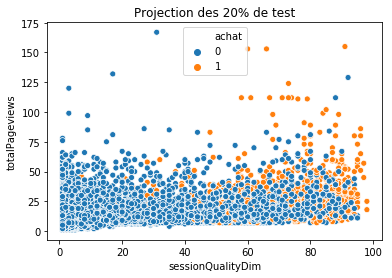

In [57]:
X = df_acp[["sessionQualityDim","totalPageviews","nbVisites"]].values
y = df_acp["achat"].values
lr = LogisticRegression()
i=0
p=0

from random import shuffle
nb_erreur = 0

# découpe du jeu d'exemples en 80 % pour l'entraînement du modèle, le reste pour son test
p = 0.8 # 80%
listeDesIndices = [i for i in range (len (X))]
shuffle (listeDesIndices)

# la liste des indices des exemples utilisés pour l'entraînement
indices_entrainement = listeDesIndices [0:int(p*len(X))]

# la liste des indices des exemples utilisés pour le test
indices_test = listeDesIndices[int(p*len(X)):len(X)]

# on entraîne le modèle
lr.fit(X[indices_entrainement], y[indices_entrainement])

# on prédit la classe des exemples du jeu de test
classe_predite = lr.predict(X[indices_test])
classe_predite_entrainement = lr.predict(X[indices_entrainement])
lr_predict=pd.DataFrame(lr.predict_proba(X[indices_test]))


# on calcule le nombre d'erreurs de prédiction
for i in range (len(indices_test)):
    if y[indices_test [i]] != classe_predite [i]:
        nb_erreur += 1
        
# et on calcule le taux d'erreur demandé
taux_erreur = nb_erreur / len (indices_test)
print("\n Le taux d'erreur est donc de : ",taux_erreur)

matrice_confusion = [[0, 0], [0, 0]]
for i in range (len (indices_test)):
    matrice_confusion [y[indices_test [i]]] [classe_predite [i]] += 1
print("\n Voici le pourcentage de non achat prédit justement :", (int(matrice_confusion[0][0]))/(int(matrice_confusion[0][0])+int(matrice_confusion[0][1])))
print("\n Voici le pourcentage d'achat prédit justement :", (int(matrice_confusion[1][1]))/(int(matrice_confusion[1][0])+int(matrice_confusion[1][1])))
results_entrainement={"sessionQualityDim":pd.DataFrame(X[indices_entrainement])[0].tolist(),"totalPageviews":pd.DataFrame(X[indices_entrainement])[1].tolist(),"achat":classe_predite_entrainement}
df_results=pd.DataFrame(results_entrainement)
ax=sns.scatterplot(x="sessionQualityDim", y="totalPageviews", hue="achat",data=df_acp)
ax.set_title("Projection des 80% d'entrainement")
plt.show()

results_test={"sessionQualityDim":pd.DataFrame(X[indices_test])[0].tolist(),"totalPageviews":pd.DataFrame(X[indices_test])[1].tolist(),"achat":classe_predite}
df_results=pd.DataFrame(results_test)
ax=sns.scatterplot(x="sessionQualityDim", y="totalPageviews", hue="achat",data=df_acp)
ax.set_title("Projection des 20% de test")
plt.show()

0.7449415334763738


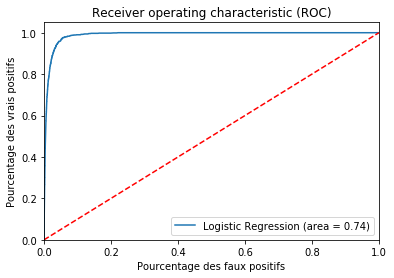

In [55]:
logit_roc_auc = roc_auc_score(y, lr.predict(X))
print(logit_roc_auc)
fpr, tpr, thresholds = roc_curve(y, lr.predict_proba(X)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Pourcentage des faux positifs')
plt.ylabel('Pourcentage des vrais positifs')
plt.title('Receiver operating characteristic (ROC)')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

In [78]:
# Répétition de 100 fois 10 régression logistique pour évaluer au mieux la qualité de la régression logistique

X = df_acp[["nbVisites","sessionQualityDim","totalPageviews"]].values
y = df_acp["achat"].values
i=0
p=0
repet=1
repet2=1     #On répete 100 fois 10 boucles pour avoir un résultat avec une approxiamtion correcte
z=0
z2=0
a=0
nb_erreur = 0
moyenne=0
colA=0
colB=0
colA2=0
colB2=0
from random import shuffle

for z in range(repet):
    colA=0
    colB=0
    z2=0
    for z2 in range(repet2):

# découpe du jeu d'exemples en 80 % pour l'entraînement du modèle, le reste pour son test
        p = 0.8 # 80%
        listeDesIndices = [i for i in range (len (X))]
        shuffle (listeDesIndices)

# la liste des indices des exemples utilisés pour l'entraînement
        indices_entrainement = listeDesIndices [0:int(p*len(X))]

# la liste des indices des exemples utilisés pour le test
        indices_test = listeDesIndices[int(p*len(X)):len(X)]

# on entraîne le modèle
        lr.fit(X[indices_entrainement], y[indices_entrainement])

# on prédit la classe des exemples du jeu de test
        classe_predite = lr.predict(X[indices_test])
        classe_predite_entrainement = lr.predict(X[indices_entrainement])
        lr_predict=pd.DataFrame(lr.predict_proba(X[indices_test]))

        matrice_confusion = [[0, 0], [0, 0]]
        for i in range (len (indices_test)):
            matrice_confusion [y[indices_test [i]]] [classe_predite [i]] += 1
    #print("\n Voici la matrice de confusion qui en découle", matrice_confusion)
        colA+=matrice_confusion[1][1]
        colB+=matrice_confusion[1][0]
    colA2+=int(colA/repet2)
    colB2+=int(colB/repet2)
print("Moyenne du nombre de vrais achats prédits : ",int(colA2/repet))
print("Moyenne du nombre de faux achats prédits : ",int(colB2/repet))
print("ratio : ",colA2/(colA2+colB2))

Moyenne du nombre de vrais achats prédits :  97
Moyenne du nombre de faux achats prédits :  91
ratio :  0.5159574468085106
